In [2]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores, get_filtered_scores
from NN import NN
from CNN import CNN
import similarities 
import DShap

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
x = []; y = []
for i in range(len(train_dataset)): 
    (xx,yy) = train_dataset.__getitem__(i) 
    x.append(xx); y.append(yy)

x_train = torch.stack(x, dim=0)
y_train = torch.tensor(y, dtype=torch.long).view(-1,1)

print(x_train.size())
print(y_train.size())

torch.Size([50000, 3, 32, 32])
torch.Size([50000, 1])


In [28]:
# split x_train into x_train and x_valid 
train_num = 40000 
valid_num = 10000 

assert train_num + valid_num <= 50000, 'only 50k obs'
_idxs = torch.randperm(50000)
train_idx = _idxs[:train_num]
valid_idx = _idxs[train_num:(train_num+valid_num)]

x_valid = x_train[valid_idx, :]
y_valid = y_train[valid_idx, :]

x_train = x_train[train_idx, :]
y_train = y_train[train_idx, :] 

print('train (x,y):', x_train.size(), y_train.size())
print('valid (x,y):', x_valid.size(), y_valid.size())

train (x,y): torch.Size([40000, 3, 32, 32]) torch.Size([40000, 1])
valid (x,y): torch.Size([10000, 3, 32, 32]) torch.Size([10000, 1])


In [29]:
x = []; y = []
for i in range(len(test_dataset)): 
    (xx,yy) = test_dataset.__getitem__(i) 
    x.append(xx); y.append(yy)

x_test = torch.stack(x, dim=0)
y_test = torch.tensor(y, dtype=torch.long).view(-1,1)

print(x_test.size())
print(y_test.size())

torch.Size([10000, 3, 32, 32])
torch.Size([10000, 1])


In [ ]:
y_train, noise_idx = corrupt_label(train_dataset.targets, noise_rate=0.2)

In [3]:
model = CNN(in_conv=3, out_conv=24, out_channels=10, kernel_size=5, hidden_channels=200, norm=True, dropout=0.2, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=1))
dvgs = DVGS(train_dataset, valid_dataset, test_dataset=None, model=model)

dvgs.pretrain_(crit=torch.nn.CrossEntropyLoss(), num_workers=5, batch_size=500, lr=1e-3, epochs=100, use_cuda=True, verbose=True, report_metric=lambda x,y: accuracy_score(x,y.argmax(axis=1)))
#dvgs.model.freeze_conv_layer()
dvgs.model.fc.reset_parameters()
print()

tic = time.time() 
vals_dvgs, grad_mag = dvgs.run(crit          = torch.nn.CrossEntropyLoss(), 
                                similarity     = similarities.cosine_similarity(), 
                                optim          = torch.optim.Adam, 
                                lr             = 1e-3, 
                                num_epochs     = 100, 
                                compute_every  = 1, 
                                batch_size     = 2000, 
                                num_workers    = 1, 
                                grad_params    = ["fc.f.0.weight","fc.f.0.bias","fc.f.3.weight","fc.f.3.bias","fc.f.4.weight","fc.f.4.bias"], 
                                verbose        = True, 
                                use_cuda       = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


using device: cuda
epoch: 99 | loss: 1.6317 | metric: 0.8280


TypeError: run() got an unexpected keyword argument 'batch_size'

In [21]:
pred = CNN(in_conv=3, out_conv=24, out_channels=10, kernel_size=5, hidden_channels=200, norm=True, dropout=0.2, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=1))
est = CNN(in_conv=3, out_conv=24, out_channels=1, kernel_size=5, hidden_channels=200, norm=True, dropout=0.2, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Sigmoid())

dvrl = DVRL(train_dataset, valid_dataset, test_dataset=None, predictor=pred, estimator=est, problem='classification')

pred = dvrl.pretrain(model=pred, dataset=train_dataset, crit=torch.nn.CrossEntropyLoss(), num_workers=1, batch_size=256, lr=1e-3, epochs=100, use_cuda=True) # epochs 100 
pred.fc.reset_parameters() 
est.conv = copy.deepcopy(pred.conv)

CEL = torch.nn.CrossEntropyLoss()
crit = lambda yhat,y: CEL(yhat, y.view(yhat.size(0)))

print()

tic = time.time() 
vals_dvrl = dvrl.run(perf_metric            = 'acc', 
                     crit_pred              = crit, 
                     outer_iter             = 1000, 
                     inner_iter             = 10,
                     outer_batch            = 50000, 
                     outer_workers          = 1, 
                     inner_batch            = 256, 
                     estim_lr               = 5e-3, 
                     pred_lr                = 1e-3, 
                     moving_average_window  = 20,
                     entropy_beta           = 0.01, 
                     entropy_decay          = 0.995,
                     fix_baseline           = False)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')      

epoch: 99 | loss: 1.6355110406875614
pretraining `ori_model` and `val_model` 


In [ ]:
dvgs_data_values = vals_dvgs.mean(axis=1)
dvrl_data_values = vals_dvrl.detach().cpu().numpy().ravel() 

pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(dvgs_data_values, noise_idx, train_size=1000, noise_prop=0.2)
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(dvrl_data_values, noise_idx, train_size=1000, noise_prop=0.2)

(1000,)
(1000,)
(1000,)


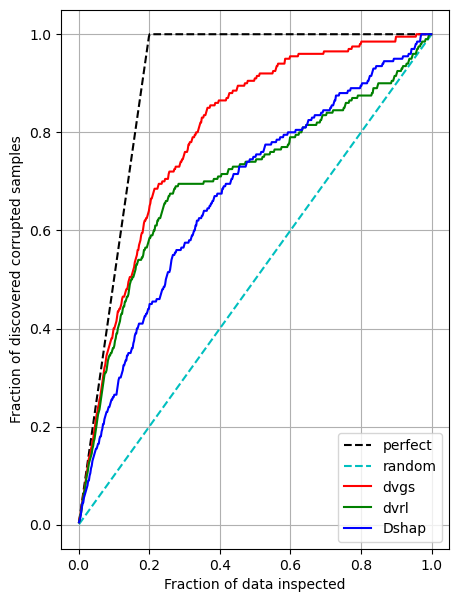

In [ ]:
plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.plot(pk, dvrl_corr, 'g-', label='dvrl')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [ ]:
model = NN(in_channels=280, out_channels=2, num_layers=2, hidden_channels=100, norm=False, dropout=0.05, bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Softmax(dim=-1))
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long))
metric = lambda y,yhat: roc_auc_score(y, yhat[:, 1]) 

rand_data_values = np.random.normal(0,1,size=dvgs_data_values.shape)

qs = np.linspace(0., 0.5, 5)
bs = 256 
nw = 1 
lr = 1e-3 
ep = 200

dvgs_low, dvgs_high = get_filtered_scores(dvgs_data_values, model, crit, metric, x_train, y_train, x_test, y_test, qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep)
dvrl_low, dvrl_high = get_filtered_scores(dvrl_data_values, model, crit, metric, x_train, y_train, x_test, y_test, qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep)
rand_low, rand_high = get_filtered_scores(rand_data_values, model, crit, metric, x_train, y_train, x_test, y_test, qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep)


In [ ]:
plt.figure()
plt.plot(qs, dvgs_low, 'r-', label='dvgs-low')
plt.plot(qs, dvgs_high, 'r--', label='dvgs-high')

plt.plot(qs, dvrl_low, 'g-', label='dvrl-low')
plt.plot(qs, dvrl_high, 'g--', label='dvrl-high')

plt.plot(qs, shap_low, 'b-', label='shap-low')
plt.plot(qs, shap_high, 'rb-', label='shap-high')

plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance (AUROC)')
plt.legend() 
plt.show()